# FWI modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering

In [2]:
M = load("model_custom.jld");

In [3]:
#model = Model(M["n"], M["d"], M["o"], M["m"])
model0 = Model(M["n"], M["d"], M["o"], M["m0"])
dm = vec(M["dm"]);

In [4]:
vmin = ones(Float32,model0.n) .* 1.5f0
vmax = ones(Float32,model0.n) .* 3.0f0;
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
block = segy_read("model_custom_low_f.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=4763124, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geouser/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


In [6]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.004f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


In [7]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [8]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [9]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [10]:
# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end

FWI iteration no: 1; function value: 62348.832
(α, misfit) = 

Building forward operator
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.02 s
Building adjoint born operator
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 

(0.1f0, 102431.6875)


Building forward operator
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.04141757495969538, 24396.12890625)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


2; function value: 24921.719


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 7481.96923828125)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


3; function value: 8087.0107


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.058956e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 10907.92578125)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0038599642858734547, 5624.64404296875)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


4; function value: 5877.56


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 16598.388671875)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.04258384695077963, 3236.53857421875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 5; function value: 3253.7754
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 209019.515625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 1410.36669921875)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


6; function value: 1655.1279


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 80525.9453125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 1572.51171875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 7; function value: 1685.2096
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 217481.921875)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 1968.974853515625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s


(0.004629957406421072, 986.7119750976562)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s


FWI iteration no: 8; function value: 1171.1061
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.

(0.1f0, 999763.9375)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 10937.9267578125)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.0010000000149011613, 897.4951171875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 9; function value: 978.34344
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 12125.7685546875)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.02126790989656606, 729.0166015625)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


10; function value: 859.4307


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 607230.0)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 6141.8857421875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0013039928910229843, 632.2465209960938)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s


11; function value: 693.74023


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 99201.2578125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 820.4246215820312)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.004621510939743587, 415.1334533691406)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s


12; function value: 585.31323


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 956622.25)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 9564.5703125)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 390.6310119628906)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


13; function value: 455.08813


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 5693.2138671875)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.02979104545935346, 645.3432006835938)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.012712836218676495, 334.81036376953125)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


14; function value: 479.27252


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 997807.8125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 9958.212890625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 331.0960998535156)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


15; function value: 418.33844


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 28385.1953125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.013397537597864596, 652.3231811523438)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.005535931572301054, 324.16778564453125)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


16; function value: 475.31537


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.0354850625e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 10480.919921875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 293.32232666015625)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s


17; function value: 367.74915


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 8896.6923828125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.02389125315533329, 636.4507446289062)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.009773664351582036, 293.42242431640625)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


18; function value: 402.24234


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.134456e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 11526.90234375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.0010000000149011613, 258.2828369140625)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


19; function value: 378.18774


Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 28735.740234375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.01366810038631212, 640.002197265625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.00559681952327972, 287.60101318359375)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


20; function value: 376.03314


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.156121375e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 10660.3388671875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 235.64688110351562)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


21; function value: 381.60114


Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 29036.591796875)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s


(0.01072926279468277, 537.047607421875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.004409388128670165, 303.2913818359375)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


22; function value: 365.95477


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.064681375e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 10798.52734375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 224.20806884765625)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


23; function value: 346.55884


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 6949.64306640625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.027649269105278117, 694.0092163085938)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.011021773356468843, 292.46710205078125)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


24; function value: 387.35193


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.202890375e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 10821.275390625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 222.86732482910156)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


25; function value: 303.3132


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 73340.5234375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 713.0753784179688)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.003433564759244321, 219.37330627441406)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


26; function value: 372.3431


Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.131625375e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 11690.505859375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.0010000000149011613, 207.446044921875)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


27; function value: 304.72833


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 4879.6064453125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.03286041163244971, 667.0842895507812)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.013166132149946264, 263.09454345703125)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


28; function value: 381.8644


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.16030225e6)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.010000000149011612, 10767.185546875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 213.00930786132812)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


29; function value: 323.1408


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 57444.40234375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 625.3087768554688)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0036199502686911898, 231.54354858398438)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


30; function value: 320.9327


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.191347e6)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 12039.1123046875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 184.21327209472656)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s


In [11]:
reshape(m0_values[:, 29], (101,101))

101×101 Matrix{Float64}:
 0.444444  0.444444  0.444444  0.444444  …  0.111397  0.111318  0.111259
 0.444444  0.444444  0.444444  0.444444     0.111435  0.111347  0.111279
 0.444444  0.444444  0.444444  0.444444     0.111475  0.111376  0.1113
 0.444444  0.444444  0.444444  0.444444     0.111515  0.111406  0.111322
 0.444444  0.444444  0.444444  0.444444     0.111556  0.111436  0.111345
 0.444444  0.444444  0.444444  0.444444  …  0.111597  0.111467  0.111367
 0.444444  0.444444  0.444444  0.444444     0.11164   0.111498  0.11139
 0.444444  0.444444  0.444444  0.444444     0.111682  0.111529  0.111413
 0.444444  0.444444  0.444444  0.444444     0.111725  0.111561  0.111435
 0.444444  0.444444  0.444444  0.444444     0.111767  0.111592  0.111458
 ⋮                                       ⋱                      ⋮
 0.444444  0.444444  0.444444  0.444444     0.11172   0.111557  0.111433
 0.444444  0.444444  0.444444  0.444444     0.111678  0.111526  0.11141
 0.444444  0.444444  0.444444  0.4444

In [12]:
fwi = sqrt.(1f0./adjoint(reshape(m0_values[:, 29], (101,101))));
v0 = sqrt.(1f0./M["m0"])';
v = sqrt.(1f0./M["m"])';

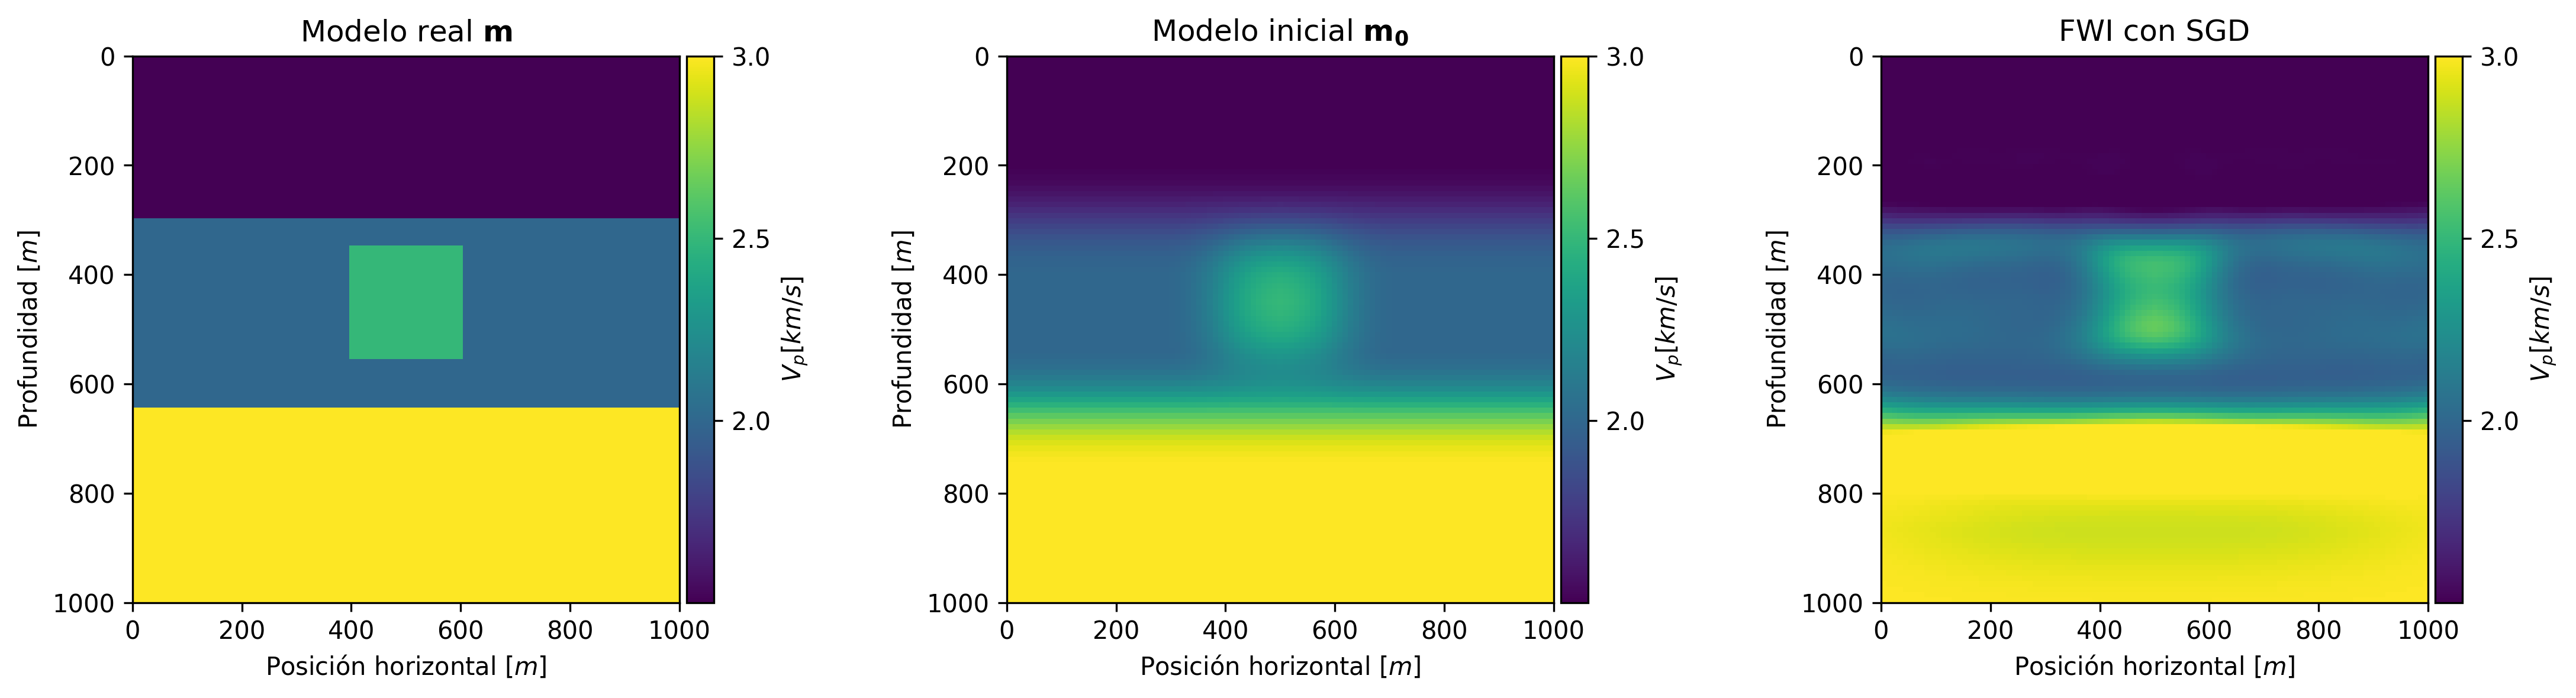

/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [13]:
fig=figure(figsize=(18,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo inicial $\mathbf{m_0}$")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI con SGD")
display(fig)

In [14]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.01610154849900713
El error cuadrático medio de FWI es: 0.010701690306282003


In [15]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 2.9251756195527445
Porcentaje de error (FWI): 2.2059062210811717


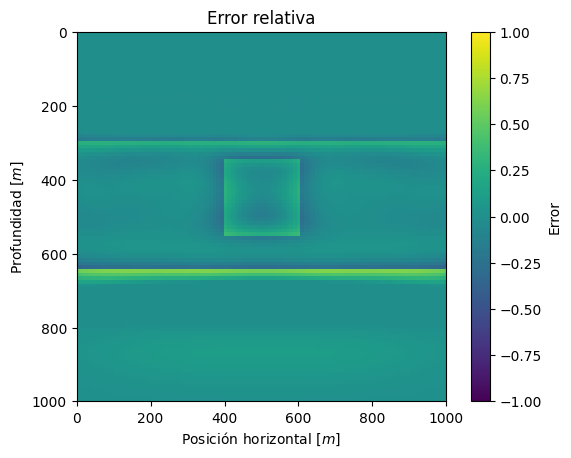

In [16]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-1, vmax=1)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

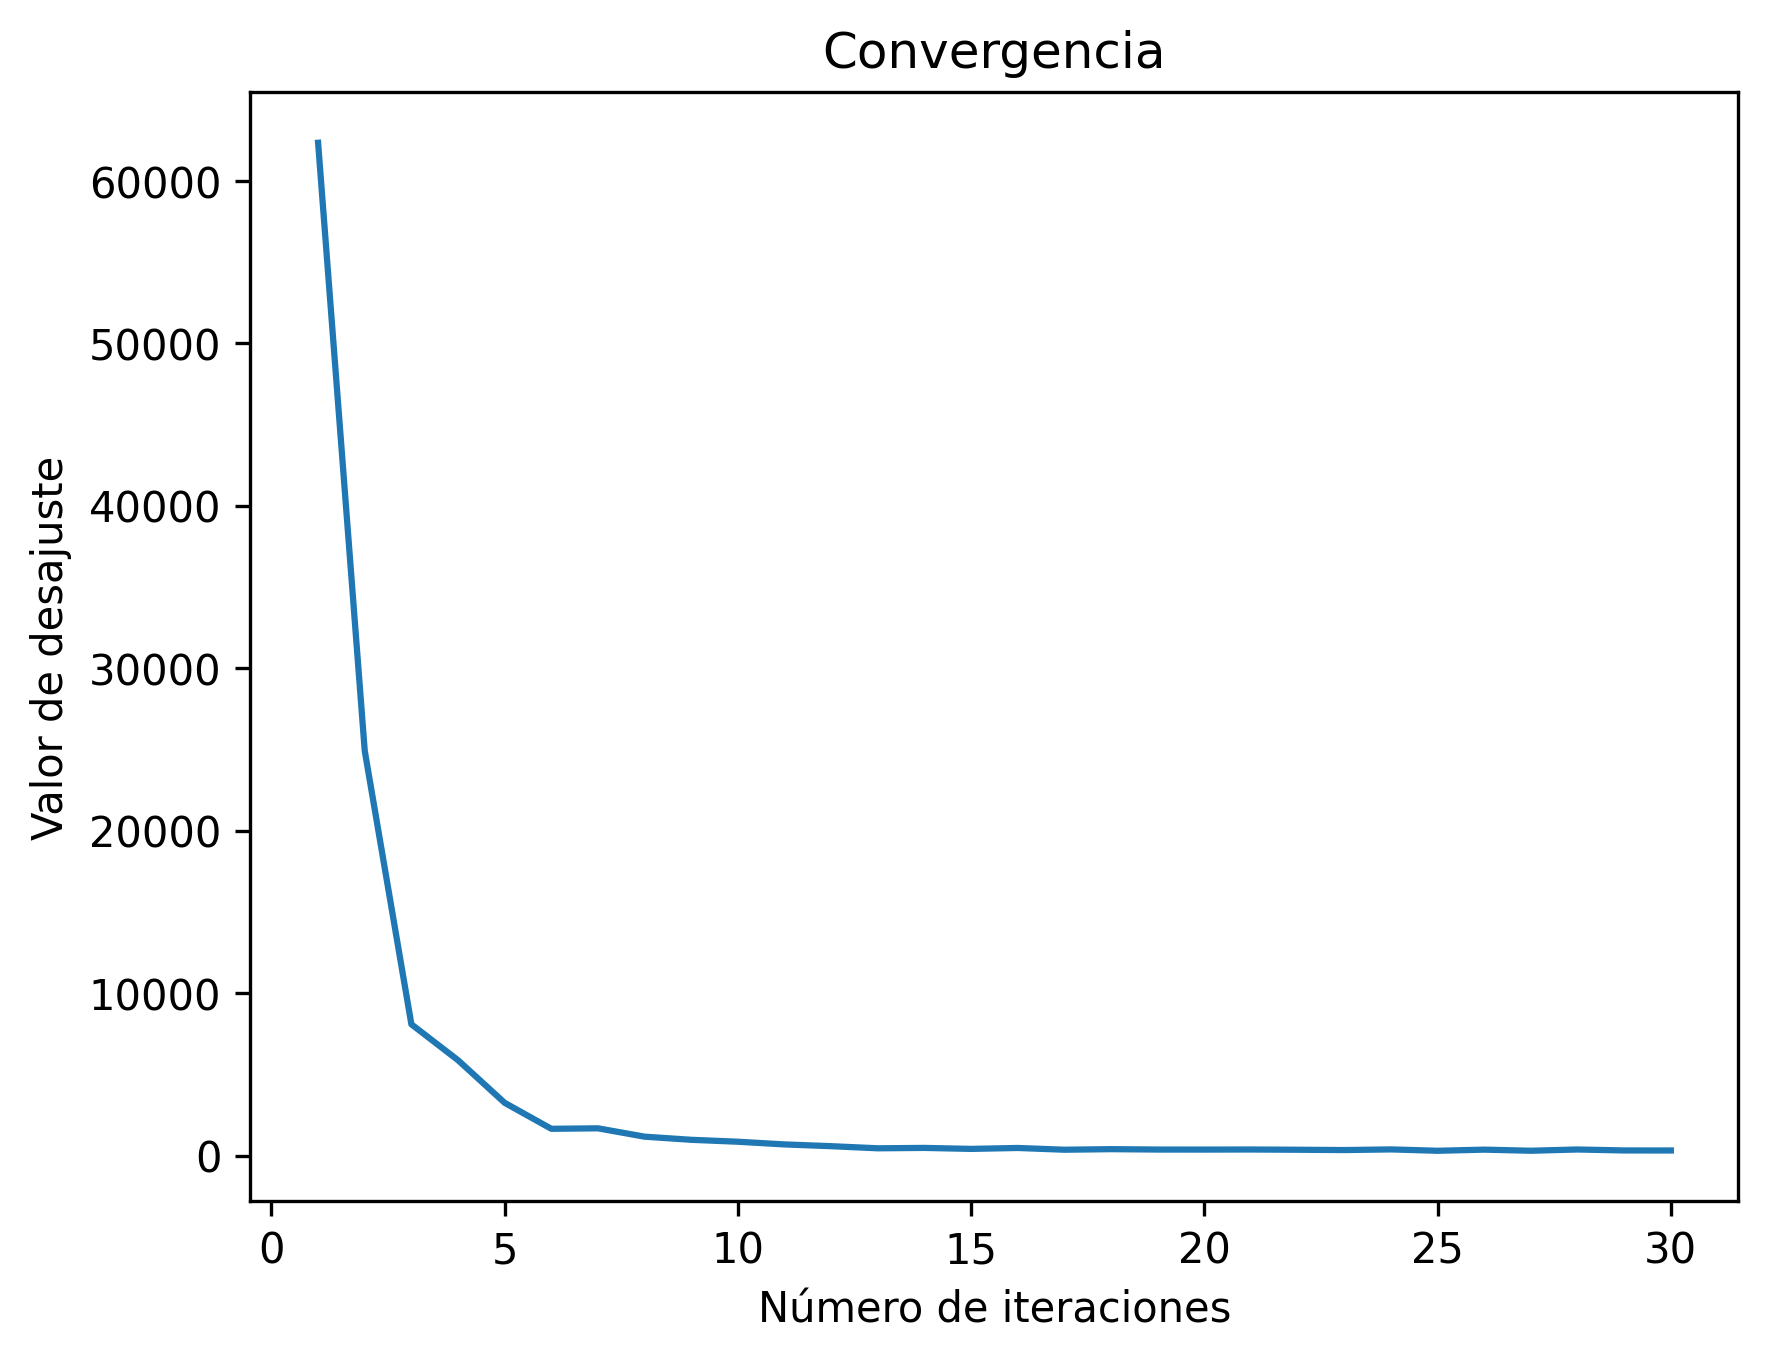

In [17]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [18]:
save("model_custom_fwi_result_low_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)